In [1]:
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [3]:
#데이터 가져오기
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
samplesubmission = pd.read_csv('../data/sample_submission.csv')

In [4]:
train.shape, test.shape, samplesubmission.shape

((79023, 76), (24353, 75), (24353, 2))

In [5]:
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.23557692307692307

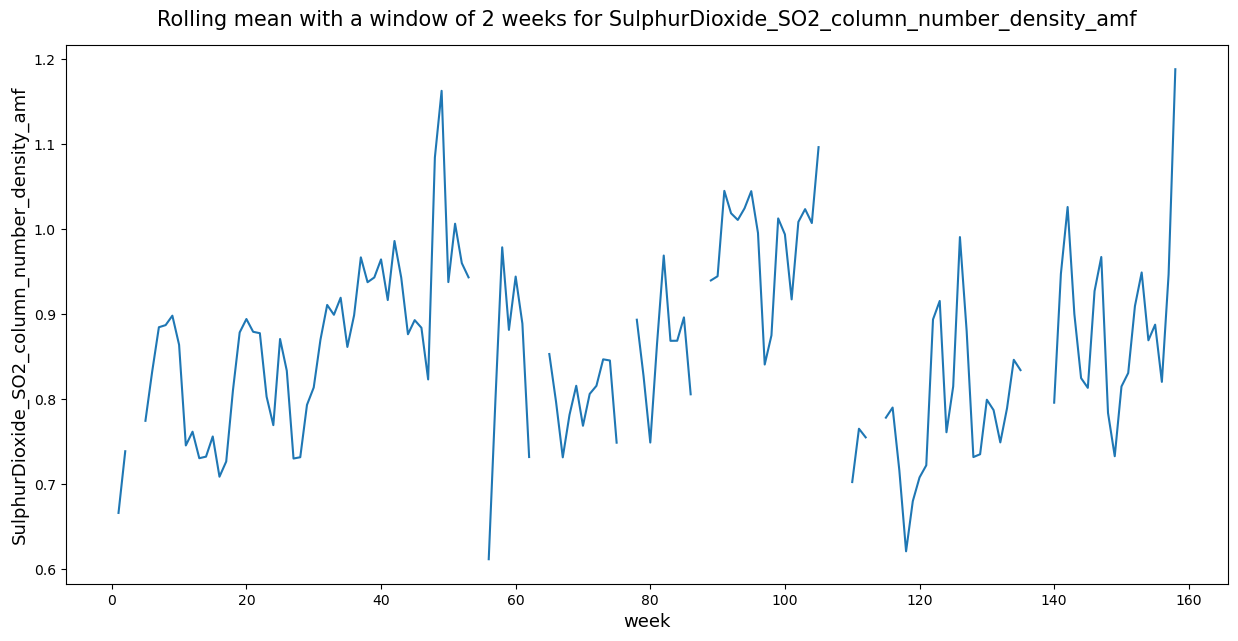

In [6]:
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]

example_loc = train[train.location == '-0.51_29.29']

rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y = 1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

In [7]:
train_roll_mean = train.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns]

test.latitude, test.longitude = round(test.latitude, 2), round(test.longitude, 2)
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]
test_roll_mean = test.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()

,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42280.88229,7474.23040,47981.82304,6474.23032,9.69203,0.26695,-65.31206,38.04982,-135.84018,32.39598
2,0.00031,0.64814,0.00021,0.03993,17.09193,27.74483,-138.71941,29.47540,0.00011,0.03772,...,41336.40886,7730.47151,46960.90116,6730.47143,11.10081,0.28012,4.28852,44.16954,-141.70891,28.87787
3,0.00026,0.65101,0.00017,0.14045,15.05711,49.37580,-144.95421,25.93065,0.00007,0.03877,...,42494.03577,7499.75988,48326.23106,6499.75991,11.25887,0.28590,7.31112,44.03845,-139.90644,28.17407
4,0.00002,0.63872,0.00003,0.20269,74.18022,37.25428,-144.39710,23.06746,0.00001,0.03949,...,48724.83811,6432.00227,55271.45512,5432.00225,12.41494,0.29445,-18.68649,36.13153,-135.26400,27.94079


In [8]:
# Merge engineered features with train and test set

#Train
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)
# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)
# Preview engineered test set
test_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,ID_-0.510_29.290_2022_00,-0.51000,29.29000,2022,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_-0.510_29.290_2022_01,-0.51000,29.29000,2022,1,0.00046,0.69116,0.00032,0.00000,76.23920,...,42280.88229,7474.23040,47981.82304,6474.23032,9.69203,0.26695,-65.31206,38.04982,-135.84018,32.39598
2,ID_-0.510_29.290_2022_02,-0.51000,29.29000,2022,2,0.00016,0.60511,0.00011,0.07987,-42.05534,...,41336.40886,7730.47151,46960.90116,6730.47143,11.10081,0.28012,4.28852,44.16954,-141.70891,28.87787
3,ID_-0.510_29.290_2022_03,-0.51000,29.29000,2022,3,0.00035,0.69692,0.00024,0.20103,72.16957,...,42494.03577,7499.75988,48326.23106,6499.75991,11.25887,0.28590,7.31112,44.03845,-139.90644,28.17407
4,ID_-0.510_29.290_2022_04,-0.51000,29.29000,2022,4,-0.00032,0.58053,-0.00018,0.20435,76.19086,...,48724.83811,6432.00227,55271.45512,5432.00225,12.41494,0.29445,-18.68649,36.13153,-135.26400,27.94079


In [9]:
X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(train_eng.mean())
y = train_eng.emission

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

clf = RandomForestRegressor( n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}')

RMSE Score: 27.662948073269558


In [10]:
X_test.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
42962,-1.96800,30.93200,2019,32,-0.00031,0.71053,-0.00022,0.05047,16.57960,45.51030,...,57419.29103,5330.79123,61552.54148,4654.78256,10.79548,0.24813,-31.46791,47.36010,-49.75059,28.81543
20489,-1.32700,30.97300,2021,31,-0.00005,0.83240,-0.00004,0.10846,17.56284,35.96635,...,61520.93314,4065.66013,69494.58153,3112.44794,10.74455,0.21591,6.19150,43.89503,-43.85110,28.08377
49300,-2.17100,28.62900,2019,10,0.00008,0.82463,0.00006,0.09100,74.80393,32.09079,...,48901.16490,4626.37383,54412.81630,3896.92843,24.60350,0.26977,-2.84187,38.80104,-98.31160,19.79850
13289,-1.11700,29.88300,2020,39,0.00005,0.83485,0.00004,0.15842,-7.92587,37.43619,...,52079.15598,5787.26982,58881.23696,4798.99914,28.16117,0.26420,10.87889,40.55605,-92.68547,23.21665
31375,-1.64100,31.25900,2019,52,0.00004,0.75535,0.00003,0.22451,75.46359,25.12664,...,44224.48788,7041.88831,50164.00427,6057.84949,15.27048,0.26619,11.59058,37.11346,-140.04970,29.57884


In [11]:
# Analyse predictions
pred_errors = X_test.copy()
pred_errors['emission'] = y_test
pred_errors['prediction'] = y_pred
pred_errors['error'] = abs(pred_errors.prediction - pred_errors.emission)
pred_errors = pred_errors[['latitude',	'longitude',	'year',	'week_no', 'emission', 'prediction', 'error']]
pred_errors.sort_values(by = 'error', ascending = False, inplace = True)
pred_errors.head()

,latitude,longitude,year,week_no,emission,prediction,error
46437,-2.07900,29.32100,2019,9,1044.48450,2921.60003,1877.11553
46490,-2.07900,29.32100,2020,9,1011.02600,2789.80255,1778.77655
56674,-2.37800,29.22200,2020,17,1502.66770,2058.34828,555.68058
56679,-2.37800,29.22200,2020,22,1689.61380,2217.15044,527.53664
56671,-2.37800,29.22200,2020,14,1777.71030,2235.02915,457.31885


In [12]:
pred_errors.tail()

,latitude,longitude,year,week_no,emission,prediction,error
70881,-2.84100,29.15900,2021,20,0.00000,0.00000,0.00000
60200,-2.49600,28.50400,2020,45,0.00000,0.00000,0.00000
72822,-2.89800,29.00200,2019,0,0.00000,0.00000,0.00000
20657,-1.32800,28.87200,2021,40,0.00000,0.00000,0.00000
33270,-1.71200,28.68800,2019,39,0.00000,0.00000,0.00000


In [13]:
train.emission.describe()

count   79023.00000
mean       81.94055
std       144.29965
min         0.00000
25%         9.79800
50%        45.59345
75%       109.54959
max      3167.76800
Name: emission, dtype: float64

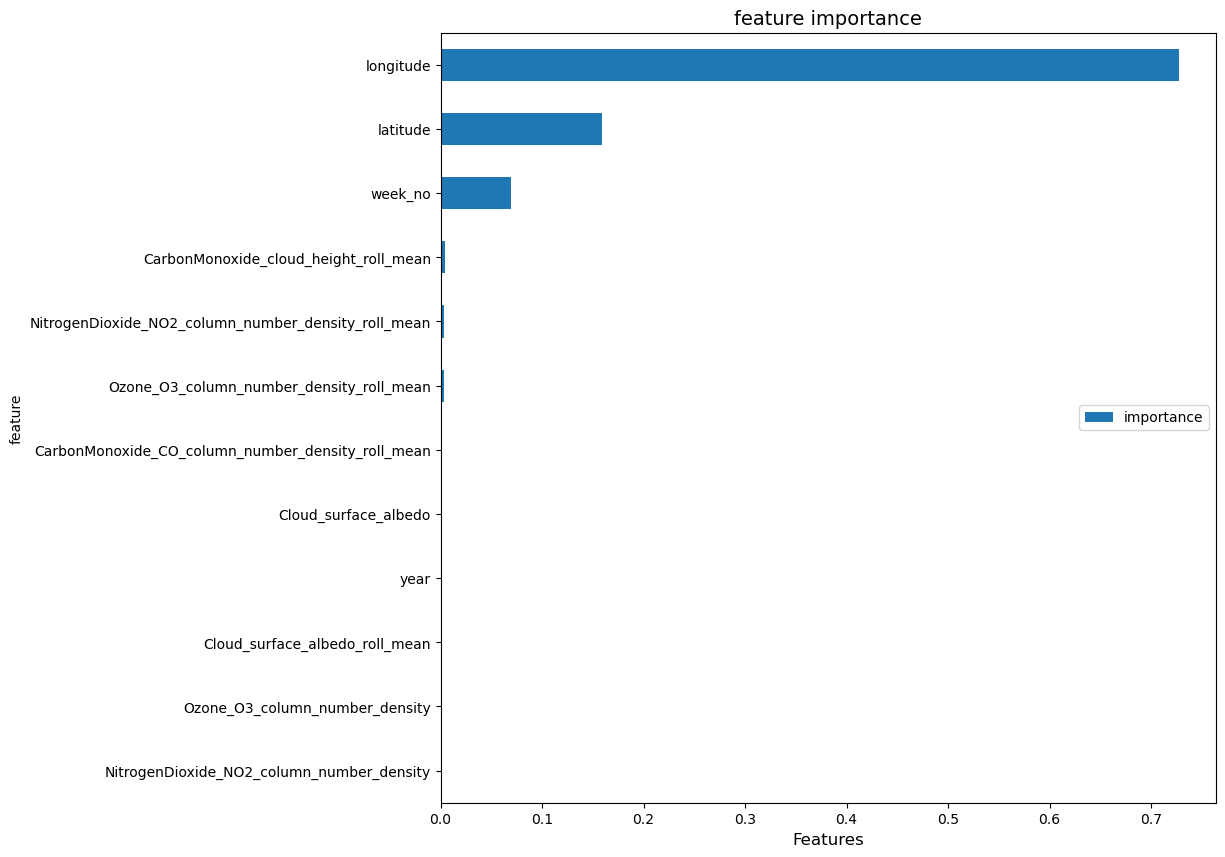

In [18]:
# 특성 중요도
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

In [15]:
# Make prediction on the test set
test_df = test_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1).fillna(0)
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_eng.ID_LAT_LON_YEAR_WEEK, 'emission': predictions})
sub_file.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,144.72475
1,ID_-0.510_29.290_2022_01,89.32604
2,ID_-0.510_29.290_2022_02,4.25919
3,ID_-0.510_29.290_2022_03,4.32505
4,ID_-0.510_29.290_2022_04,145.15605


In [19]:
# Create file
sub_file.to_csv('BaselineSubmission.csv', index = False) # Download and submit, or submit via Notebook output